In [12]:
from __future__ import print_function, division

import keras.backend as K
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
#from keras.layers.advanced_activations import LeakyReLU
from keras.layers import ELU, PReLU, LeakyReLU
from keras.layers import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers.legacy import Adam
from keras.utils import Progbar

import matplotlib.pyplot as plt

import numpy as np

#K.set_image_dim_ordering('th')
#K.set_image_data_format('channels_first')

# Input shape
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_cols,img_rows,channels)
num_classes = 10
latent_dim = 100

In [13]:
def build_generator():

    model = Sequential()

    model.add(Dense(128 * 7 * 7, activation="relu", input_dim=latent_dim))
    model.add(Reshape((7, 7, 128)))
    model.add(BatchNormalization(momentum=0.8))
    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size=3, padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(UpSampling2D())
    model.add(Conv2D(64, kernel_size=3, padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2D(channels, kernel_size=3, padding='same'))
    model.add(Activation("tanh"))

    model.summary()

    noise = Input(shape=(latent_dim,))
    label = Input(shape=(1,), dtype='int32')
    label_embedding = Flatten()(Embedding(num_classes, 100)(label))

    model_input = multiply([noise, label_embedding])
    img = model(model_input)

    return Model([noise, label], img)

def build_discriminator():

    model = Sequential()

    model.add(Conv2D(16, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(32, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.summary()

    img = Input(shape=img_shape)

    # Extract feature representation
    features = model(img)

    # Determine validity and label of the image
    validity = Dense(1, activation="sigmoid")(features)
    label = Dense(num_classes+1, activation="softmax")(features)

    return Model(img, [validity, label])




In [14]:


optimizer = Adam(0.0002, 0.5)
losses = ['binary_crossentropy', 'sparse_categorical_crossentropy']

# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss=losses, optimizer=optimizer,  metrics=['accuracy'])
discriminator.summary()
# Build the generator
generator = build_generator()
print("##############################################")
generator.summary()

# The generator takes noise and the target label as input
# and generates the corresponding digit of that label
noise = Input(shape=(latent_dim,))
label = Input(shape=(1,))
img = generator([noise, label])

# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated image as input and determines validity
# and the label of that image
#img = np.expand_dims(img, axis=1)
#print(img.input_shape)
print(img_shape)
valid, target_label = discriminator(img)

# The combined model  (stacked generator and discriminator)
# Trains the generator to fool the discriminator
combined = Model([noise, label], [valid, target_label])
combined.compile(loss=losses,
    optimizer=optimizer)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 14, 14, 16)        160       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 14, 14, 16)        0         
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 16)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 7, 7, 32)          4640      
                                                                 
 zero_padding2d_1 (ZeroPadd  (None, 8, 8, 32)          0         
 ing2D)                                                          
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 8, 8, 32)          0         
                                                      

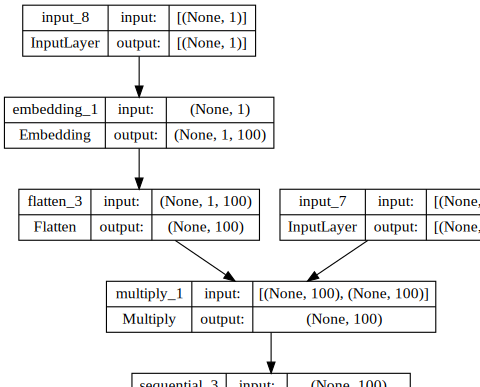

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 input_10 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 model_4 (Functional)        (None, 28, 28, 1)            857705    ['input_9[0][0]',             
                                                                     'input_10[0][0]']            
                                                                                                  
 model_3 (Functional)        [(None, 1),                  122124    ['model_4[0][0]']       

In [15]:
from IPython.display import SVG,display
from keras.utils import model_to_dot
modelSVG=SVG(model_to_dot(generator,show_shapes=True, dpi=65).create(prog='dot', format='svg'))
display(modelSVG)
combined.summary()

In [16]:
def train(epochs, batch_size=128, sample_interval=50):

    # Load the dataset
    (X_train, y_train), (_, _) = mnist.load_data()

    # Configure inputs
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    #X_train = X_train[:, :, :, np.newaxis]
    X_train = np.expand_dims(X_train, axis=3)
    print(X_train.shape)

    print(y_train)
    print("---------------------")

    y_train = y_train.reshape(-1, 1)
    print(y_train)

    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):

        print('Epoch {} of {}'.format(epoch + 1, epochs))
        print(epoch)
        nb_batches = int(X_train.shape[0] / batch_size)
        progress_bar = Progbar(target=nb_batches)

        epoch_gen_loss = []
        epoch_disc_loss = []
        epoch_disc_sigmoid_acc = []
        epoch_disc_softmax_acc = []

        epoch_gen_loss_test = []
        epoch_disc_loss_test = []
        epoch_disc_sigmoid_acc_test = []
        epoch_disc_softmax_acc_test = []

        for index in range(nb_batches):
            # get a batch of real images
            progress_bar.update(index)
            imgs = X_train[index * batch_size:(index + 1) * batch_size]
            img_labels = y_train[index * batch_size:(index + 1) * batch_size]

            # Select a random batch of images
            ##idx = np.random.randint(0, X_train.shape[0], batch_size)
            ##imgs = X_train[idx]
            # Image labels. 0-9
            ##img_labels = y_train[idx]

            # ---------------------
            #  Train Discriminator
            # ---------------------



            # Sample noise as generator input
            noise = np.random.normal(0, 1, (batch_size, 100))

            # The labels of the digits that the generator tries to create an
            # image representation of
            sampled_labels = np.random.randint(0, 10, (batch_size, 1))

            # Generate a half batch of new images
            gen_imgs = generator.predict([noise, sampled_labels])



            ##
            #fake_labels = 10 * np.ones(img_labels.shape)

            # Train the discriminator
            d_loss_real = discriminator.train_on_batch(imgs, [valid, img_labels])
            d_loss_fake = discriminator.train_on_batch(gen_imgs, [fake, sampled_labels])

            ##
            ##d_loss_fake = discriminator.train_on_batch(gen_imgs, [fake, fake_labels])

            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator
            g_loss = combined.train_on_batch([noise, sampled_labels], [valid, sampled_labels])

            # Plot the progress
            #print ("%d [D loss: %f, acc.: %.2f%%, op_acc: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[3], 100*d_loss[4], g_loss[0]))
            #print (discriminator.metrics_names)

            # If at save interval => save generated image samples
            if index % sample_interval == 0:
                #save_model()
                sample_images(index)
        if epoch % sample_interval == 0:
            save_model()
            sample_images(epoch)

def sample_images(epoch):
    r, c = 10, 10
    noise = np.random.normal(0, 1, (r * c, 100))
    sampled_labels = np.array([num for _ in range(r) for num in range(c)])
    gen_imgs = generator.predict([noise, sampled_labels])
    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("images/%d.png" % epoch)
    plt.close()
    print("epoch save",epoch)

def save_model():

    def save(model, model_name):
        model_path = "saved_model/%s.json" % model_name
        weights_path = "saved_model/%s_weights.hdf5" % model_name
        options = {"file_arch": model_path,
                    "file_weight": weights_path}
        json_string = model.to_json()
        open(options['file_arch'], 'w').write(json_string)
        model.save_weights(options['file_weight'])

    save(generator, "generator")
    save(discriminator, "discriminator")

In [ ]:
train(epochs=600, batch_size=32, sample_interval=200)

(60000, 28, 28, 1)
[5 0 4 ... 5 6 8]
---------------------
[[5]
 [0]
 [4]
 ...
 [5]
 [6]
 [8]]
Epoch 1 of 600
0
1/1 [==============================] - 0s 116ms/step


4/4 [==============================] - 0s 53ms/step
epoch save 0
4/4 [==============================] - 0s 4ms/step
epoch save 200
4/4 [==============================] - 0s 4ms/step
epoch save 400
4/4 [==============================] - 0s 3ms/step
epoch save 600
4/4 [==============================] - 0s 4ms/step
epoch save 800
4/4 [==============================] - 0s 3ms/step
epoch save 1000
4/4 [==============================] - 0s 4ms/step
epoch save 1200
4/4 [==============================] - 0s 4ms/step
epoch save 1400
4/4 [==============================] - 0s 3ms/step
epoch save 1600
4/4 [==============================] - 0s 3ms/step
epoch save 1800
4/4 [==============================] - 0s 5ms/step
epoch save 0
Epoch 2 of 600
1
4/4 [==============================] - 0s 3ms/step
epoch save 0
4/4 [==============================] - 0s 3ms/step
epoch save 200
4/4 [==============================] - 0s 3ms/step
epoch save 400
4/4 [==============================] - 0s 4ms/step
epoch sa

In [ ]:
n = 10
noise = np.random.normal(0, 1, (n, 100))

# The labels of the digits that the generator tries to create an
# image representation of
sampled_labels = np.random.randint(8, 9, (n, 1))

# Generate a half batch of new images
decoded_imgs = generator.predict([noise, sampled_labels])



plt.figure(figsize=(20, 4))
for i in range(n):
    # display reconstruction
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

NameError: ignored